In [19]:
import fitparse

import numpy
import pandas as pd
import os

from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.signal import lfilter, savgol_filter

from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=False)

import bokeh

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (20.0, 10.0)

In [307]:
fitfiles = 'fit_files'

In [4]:
activites = {}
sessions = {}
for file in os.listdir(fitfiles):
    filename = os.path.join(files, file)
    fitfile = fitparse.FitFile(filename, check_crc=False)
    sport_rec = list(fitfile.get_messages('sport'))
    assert len(sport_rec) == 1, 'Wrong length for sport'
    sport = sport_rec[0].get_values()
    activites[file] = sport
    
    session = list(fitfile.get_messages('session'))[0]
    sessions[file] = session.get_values()

In [5]:
# activites_df = pd.DataFrame.from_dict(activites, orient='index')
# sessions_df = pd.DataFrame.from_dict(sessions, orient='index')
df = pd.DataFrame.from_dict(sessions, orient='index')
# df = pd.merge(activites_df, sessions_df, left_index=True, right_index=True)

In [262]:
list(df.columns)

['timestamp',
 'start_time',
 'start_position_lat',
 'start_position_long',
 'total_elapsed_time',
 'total_timer_time',
 'total_distance',
 'total_cycles',
 'nec_lat',
 'nec_long',
 'swc_lat',
 'swc_long',
 'unknown_38',
 'unknown_39',
 'avg_stroke_count',
 'total_work',
 'unknown_78',
 'unknown_110',
 'time_standing',
 'avg_left_power_phase',
 'avg_left_power_phase_peak',
 'avg_right_power_phase',
 'avg_right_power_phase_peak',
 'avg_power_position',
 'max_power_position',
 'unknown_152',
 'message_index',
 'total_calories',
 'enhanced_avg_speed',
 'avg_speed',
 'enhanced_max_speed',
 'max_speed',
 'avg_power',
 'max_power',
 'total_ascent',
 'total_descent',
 'first_lap_index',
 'num_laps',
 'unknown_33',
 'normalized_power',
 'training_stress_score',
 'intensity_factor',
 'left_right_balance',
 'avg_stroke_distance',
 'pool_length',
 'threshold_power',
 'num_active_lengths',
 'unknown_79',
 'unknown_80',
 'avg_vertical_oscillation',
 'avg_stance_time_percent',
 'avg_stance_time',
 '

In [6]:
df['sport'].value_counts()

running     66
cycling     17
hiking      16
kayaking     2
swimming     1
Name: sport, dtype: int64

In [7]:
df['sub_sport'].value_counts()

trail           62
generic         28
mountain        11
lap_swimming     1
Name: sub_sport, dtype: int64

In [498]:
fitfile = fitparse.FitFile(os.path.join(fitfiles, df[df['sport'] == 'running'].sort_values('timestamp').index[-4]))

In [499]:
d = {}
step = 0
# Get all data messages that are of type record
for record in fitfile.get_messages('record'):
    d[step] = record.get_values()
    step += 1

In [500]:
data = pd.DataFrame.from_dict(d, orient='index')
data.head()

timestamp  position_lat  position_long  distance  \
0 2019-07-18 16:59:56     562321056       62179063      1.67   
1 2019-07-18 16:59:57     562320904       62179249      3.48   
2 2019-07-18 16:59:58     562320731       62179511      5.78   
3 2019-07-18 16:59:59     562320619       62179845      8.14   
4 2019-07-18 17:00:00     562320521       62180226     10.72   

   enhanced_altitude  altitude  enhanced_speed  speed  vertical_oscillation  \
0              183.0      3415           0.000      0                   4.7   
1              183.0      3415           0.000      0                  67.2   
2              182.8      3414           0.000      0                  82.0   
3              182.8      3414           0.000      0                 105.2   
4              182.8      3414           0.778    778                 105.2   

   stance_time_percent  ...  step_length  unknown_87  unknown_88  heart_rate  \
0                47.75  ...        320.0           0         300          60   
1                42.25  ...        324.0           0         300          61   
2                41.00  ...        636.0           0         300          67   
3                39.75  ...        684.0           0         300          71   
4                39.75  ...        895.0           0         300          75   

   cadence  temperature  activity_type  fractional_cadence  RP_Power  \
0      116           31        running                 0.5         0   
1       53           31        running                 0.5         0   
2       60           31        running                 0.0         0   
3       76           31        running                 0.0         0   
4       76           31        running                 0.0         0   

  unknown_108  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

[5 rows x 23 columns]

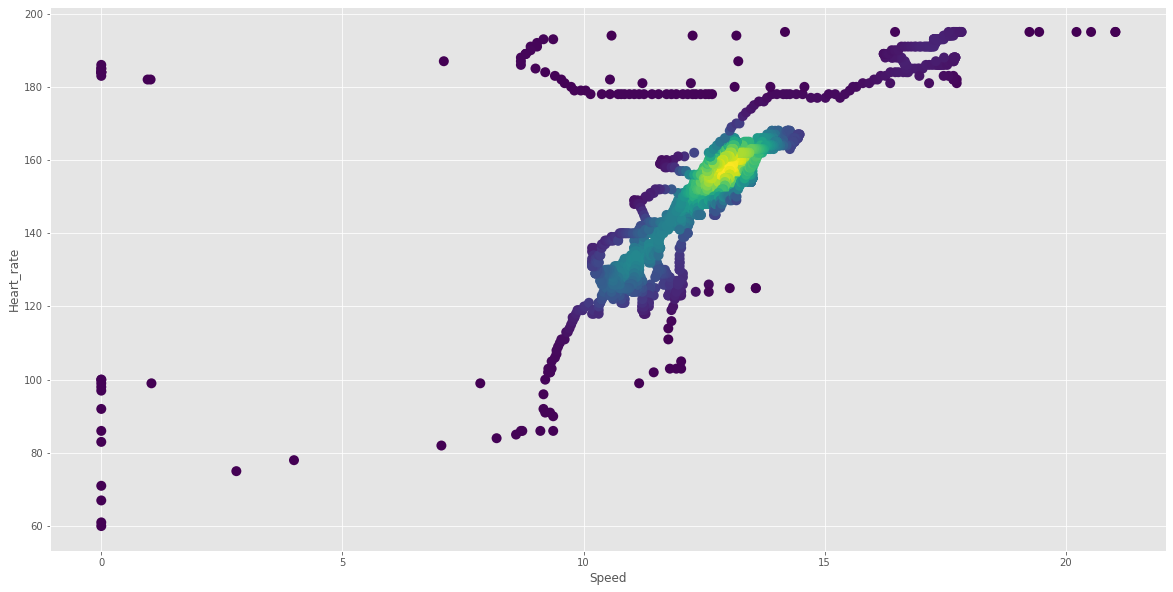

In [501]:
x = data['enhanced_speed'] * 3.6
y = data['heart_rate']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')
ax.set_xlabel('Speed')
ax.set_ylabel('Heart_rate')
plt.show()

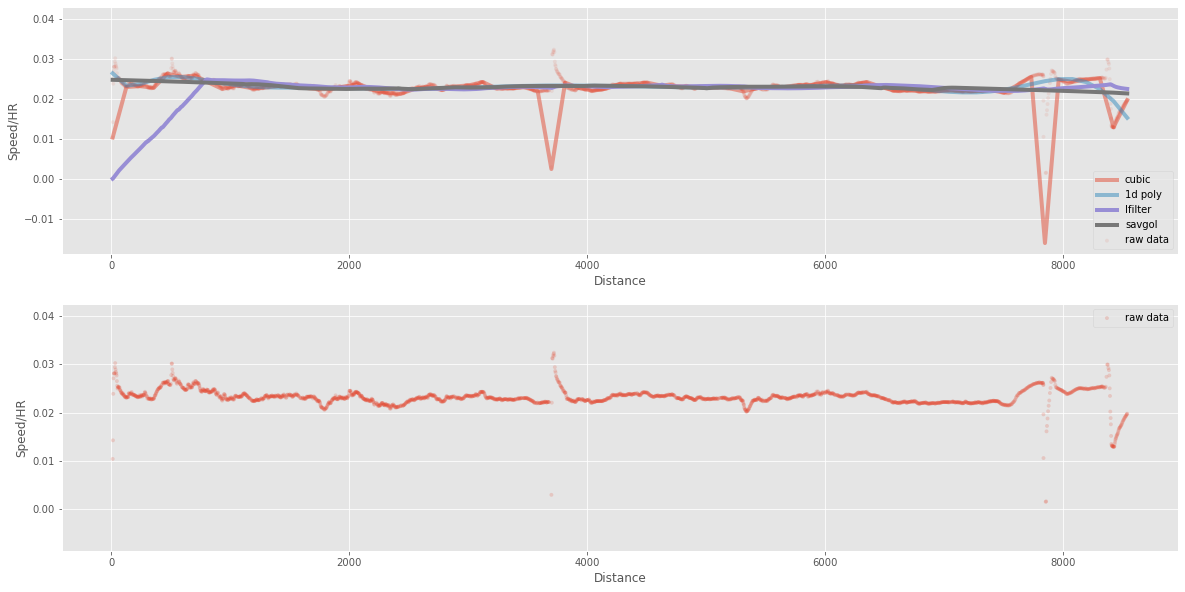

In [502]:
indexs = data['distance'].drop_duplicates(keep=False).index
indexs = data.loc[indexs][data.loc[indexs]['enhanced_speed']!= 0].index
x = data.loc[indexs, 'distance'].values
y = (data.loc[indexs,'enhanced_speed']/data.loc[indexs,'heart_rate']).values

f = interp1d(x, y, kind='cubic')
xnew = numpy.linspace(numpy.min(x), numpy.max(x), num=75, endpoint=True)

z = numpy.polyfit(x, y, 15)
p = numpy.poly1d(z)

n = 250  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy = lfilter(b,a,y)

w = savgol_filter(y, 701, 2)

fig, axes = plt.subplots(2)
ax, ax1 = axes
ax.scatter(x, y, s=15, edgecolor='', alpha=0.1, label='raw data')
ax.plot(xnew, f(xnew), linewidth=4, alpha=0.5, label='cubic') # cubic interp
ax.plot(xnew, p(xnew), linewidth=4, alpha=0.5, label='1d poly') # 1d poly
ax.plot(x, yy, linewidth=4, label='lfilter')  # smooth by filter
ax.plot(x, w, linewidth=4, label='savgol')

ax1.scatter(x, y, s=15, edgecolor='', alpha=0.2, label='raw data')
# ax1.plot(x, w, linewidth=4, label='savgol', c='grey')

ax.legend()
ax.set_xlabel('Distance');
ax.set_ylabel('Speed/HR');

ax1.legend()
ax1.set_xlabel('Distance');
ax1.set_ylabel('Speed/HR');

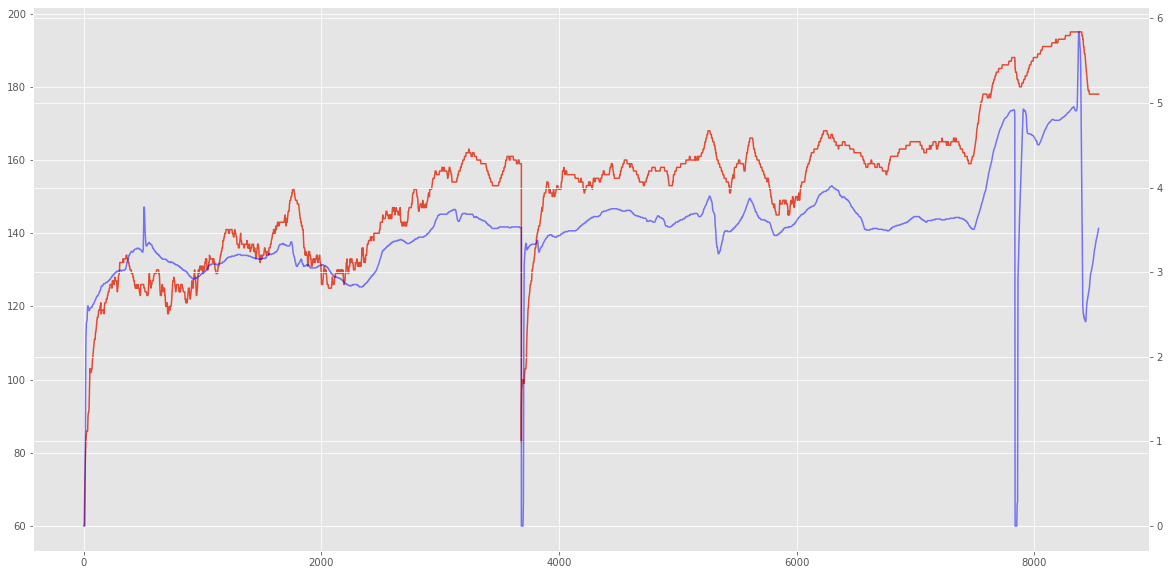

In [503]:
fig, ax1 = plt.subplots()
ax1.plot(data['distance'], data['heart_rate'], label='HR')
ax2 = plt.twinx(ax1)
ax2.plot(data['distance'], data['enhanced_speed'], label='speed', c='b', alpha=0.5)

In [506]:
lag = numpy.argmax(correlate(data['heart_rate'], data['enhanced_speed']))
lagged_data = numpy.roll(data['enhanced_speed'], int(numpy.ceil(lag)))

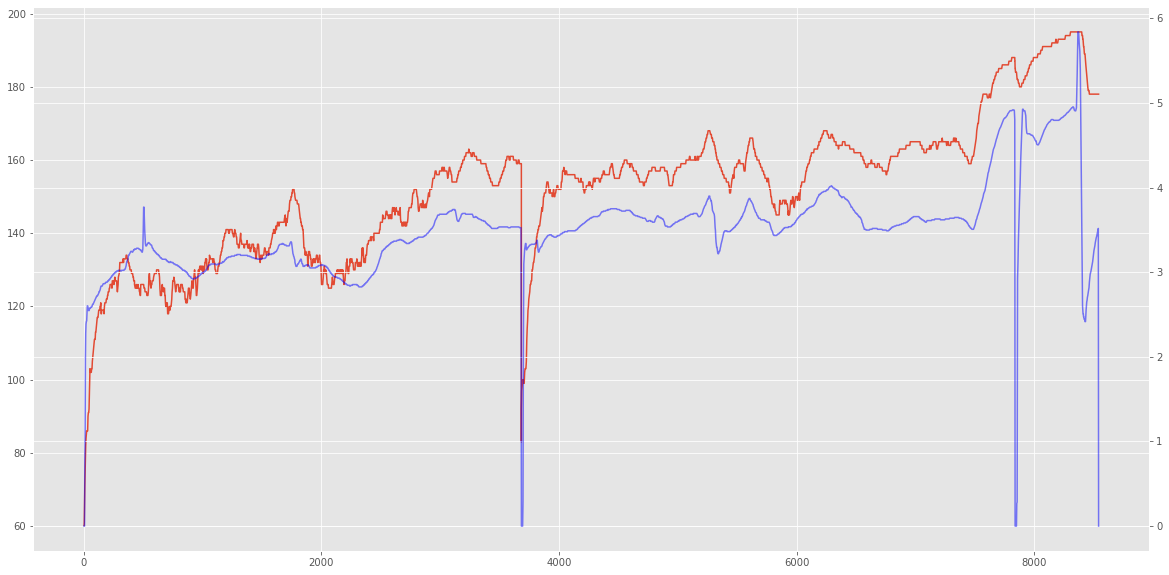

In [507]:
fig, ax1 = plt.subplots()
ax1.plot(data['distance'], data['heart_rate'], label='HR')
ax2 = plt.twinx(ax1)
ax2.plot(data['distance'], lagged_data, label='speed', c='b', alpha=0.5)

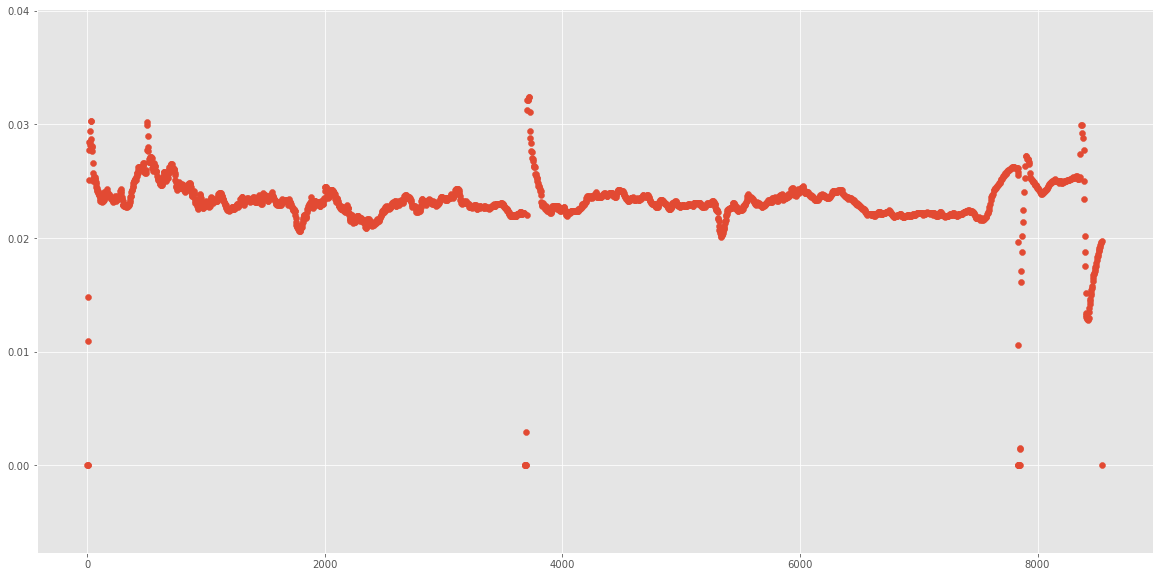

In [508]:
plt.scatter(data['distance'], lagged_data/data['heart_rate'])

In [25]:
# Get all data messages that are of type record
for record in fitfile.get_messages('record'):

    # Go through all the data entries in this record
    for record_data in record:

        # Print the records name and value (and units if it has any)
        if record_data.units:
            print(" * %s: %s %s" % (
                record_data.name, record_data.value, record_data.units,
            ))
        else:
            print(" * %s: %s" % (record_data.name, record_data.value))
    print()
    break

 * RP_Power: 122 W
 * activity_type: running
 * cadence: 42 rpm
 * distance: 0.0 m
 * enhanced_altitude: 1434.4 m
 * enhanced_speed: 1.222 m/s
 * fractional_cadence: 0.5 rpm
 * heart_rate: 112 bpm
 * position_lat: 512417050 semicircles
 * position_long: -7926590 semicircles
 * stance_time: 554.0 ms
 * stance_time_balance: 50.68 percent
 * stance_time_percent: 50.0 percent
 * step_length: 1292.0 mm
 * temperature: 30 C
 * timestamp: 2019-07-25 07:56:42
 * vertical_oscillation: 92.7 mm
 * vertical_ratio: 10.15 percent
 * unknown_87: 0
 * unknown_88: 300



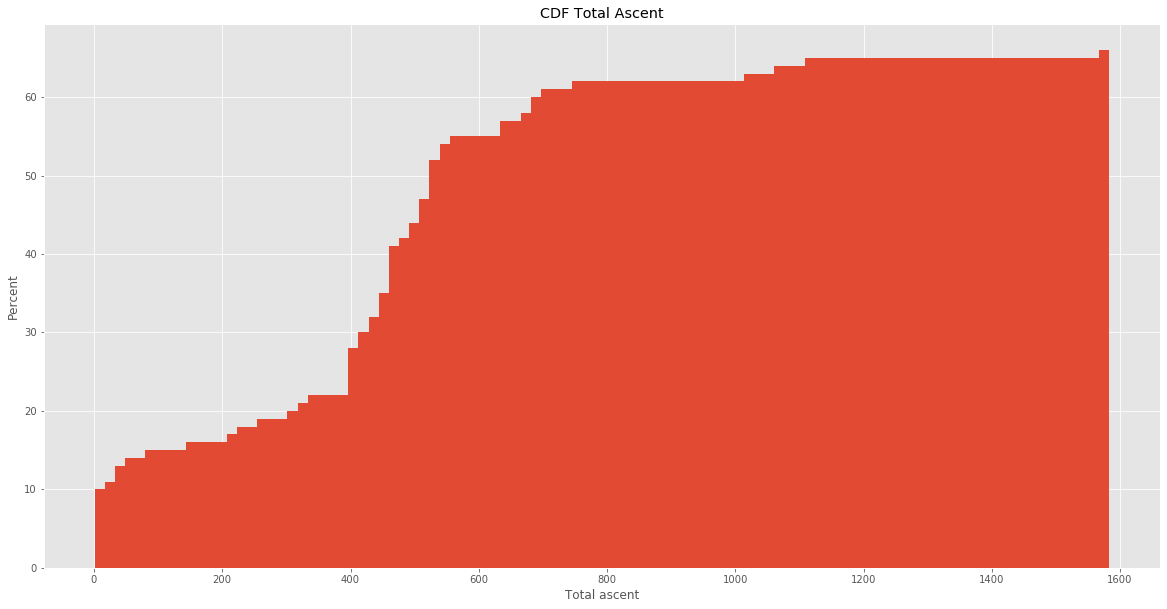

In [282]:
ax = df[df['sport'] == 'running']['total_ascent'].dropna().hist(cumulative=True, bins=100);
ax.set_xlabel('Total ascent');
ax.set_ylabel('Percent');
ax.set_title('CDF Total Ascent');

In [308]:
files = df[(df['sport'] == 'running') & (df['total_ascent'] < 200)].index.values
len(files)

16

In [309]:
running_data = None
for filename in files:
    fitfile = fitparse.FitFile(os.path.join(fitfiles, filename))
    d = {}
    step = 0
    # Get all data messages that are of type record
    for record in fitfile.get_messages('record'):
        d[step] = record.get_values()
        step += 1

    data = pd.DataFrame.from_dict(d, orient='index')
    data['filename'] = filename
    if running_data is None:
        running_data = data
    else:
        running_data = running_data.append(data.copy())
running_data = running_data.reset_index()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




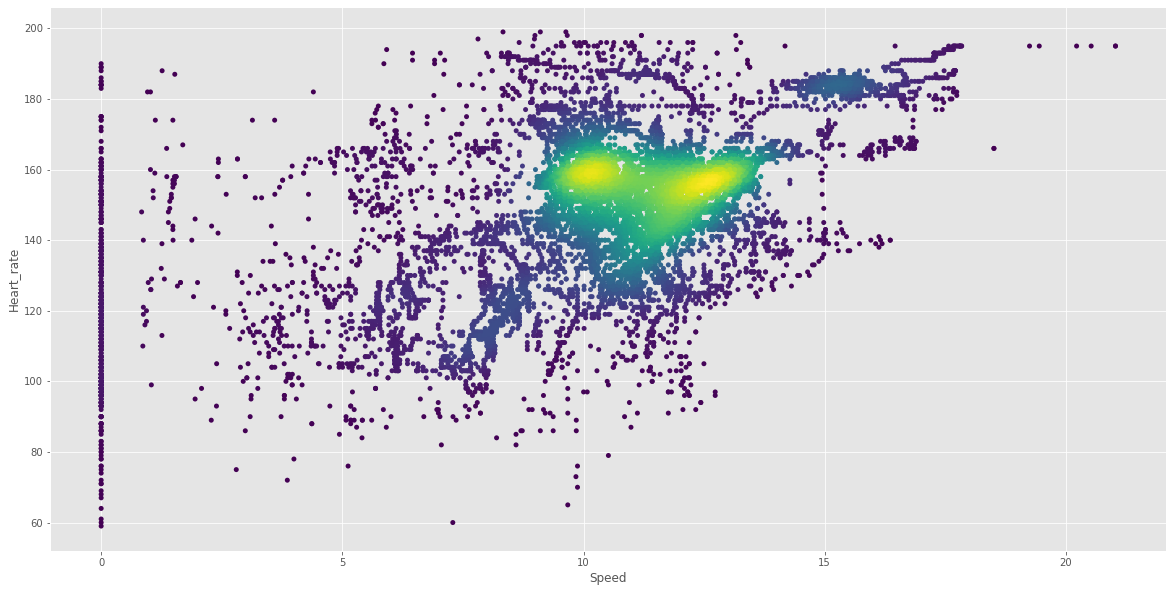

In [413]:
indexs = running_data.loc[:, ['enhanced_speed', 'heart_rate']].dropna().index

x = running_data.loc[indexs, 'enhanced_speed'] * 3.6
y = running_data.loc[indexs, 'heart_rate']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=25, edgecolor='')
ax.set_xlabel('Speed')
ax.set_ylabel('Heart_rate')
plt.show()

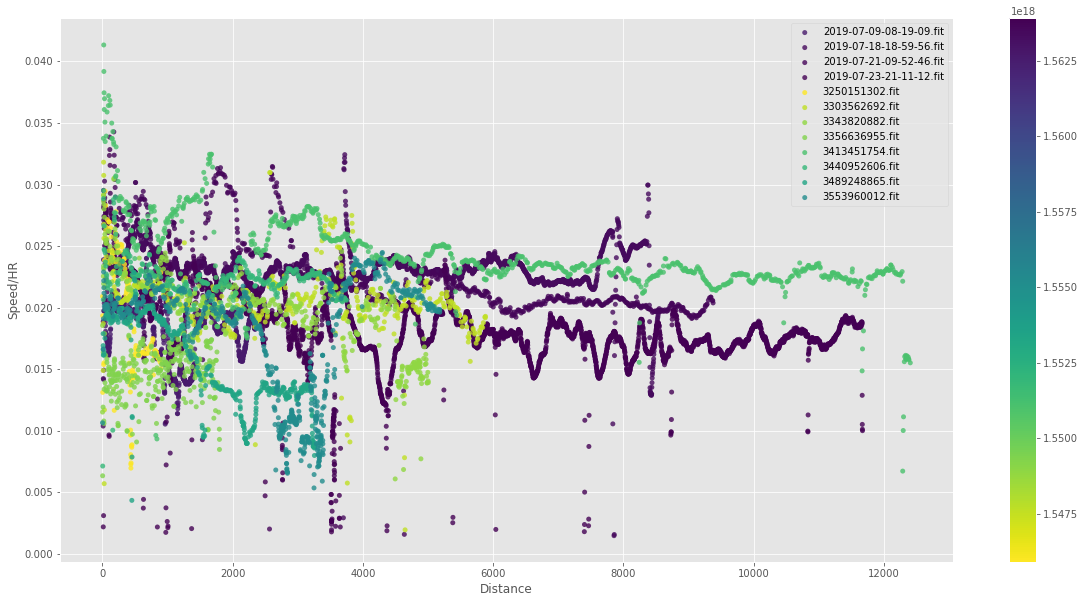

In [412]:
indexs = running_data.loc[:, ['distance', 'enhanced_speed', 'heart_rate']].dropna().drop_duplicates(keep=False).index
indexs = running_data.loc[indexs][running_data.loc[indexs]['enhanced_speed']!= 0].index

cm = plt.get_cmap('viridis_r') 
vmin, vmax = df[df.index.isin(running_data.loc[indexs].filename.unique())]['timestamp'].describe()[['first', 'last']]
cNorm  = colors.Normalize(vmin=vmin.value, vmax=vmax.value)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots()
for name, dff in running_data.loc[indexs].groupby('filename'):
    x = dff.loc[indexs, 'distance'].values
    y = (dff.loc[indexs,'enhanced_speed']/dff.loc[indexs,'heart_rate']).values
    color_val = scalarMap.to_rgba(df.loc[dff.iloc[0]['filename']]['timestamp'].value)
    ax.scatter(x, y, s=25, edgecolor='', alpha=0.8, label=name, color=color_val)
    
ax.legend()
fig.colorbar(scalarMap)
ax.set_xlabel('Distance');
ax.set_ylabel('Speed/HR');

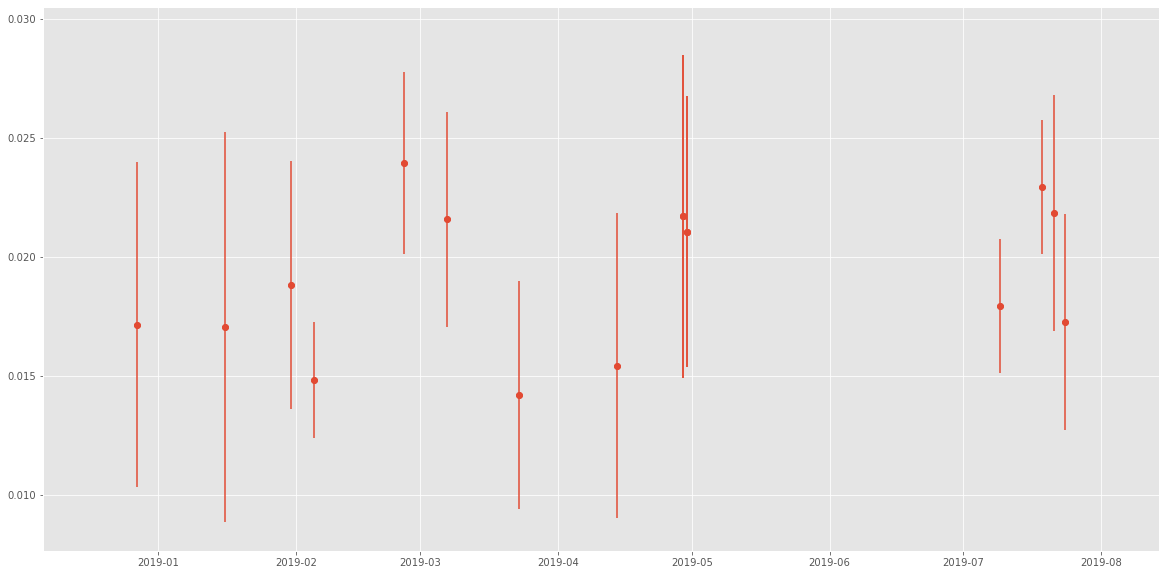

In [444]:
x = []
y = []
stds = []
for name, dff in running_data.groupby('filename'):
    x.append(dff['timestamp'].iloc[0])
    y.append((dff['enhanced_speed'] / dff['heart_rate']).mean())
    stds.append((dff['enhanced_speed'] / dff['heart_rate']).std())
# plt.scatter(x ,y);
plt.errorbar(x, y, yerr=stds, fmt='o');